# Direct Impact Calculations from Wind & Flooding Damage to Critical Infrastructures from TC IDAI (Mozambique)

In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import shapely
import os
import pickle
import numpy as np

from scipy.sparse import csr_matrix
from datetime import datetime

# on climada_petals branch feature/networks until merged!
from climada_petals.engine.networks import nw_utils as nwu
from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

# on climada_python develop branch
from climada.util import coordinates as u_coords
from climada.entity.exposures.base import Exposures
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet
from climada.engine import Impact
from climada.hazard.base import Hazard
from climada.util import lines_polys_handler as u_lp
from climada.util.api_client import Client

from climada_petals.entity.exposures.openstreetmap import osm_dataloader as osm
from climada_petals.util.constants import DICT_GEOFABRIK

from climada.util import coordinates as u_coords
from climada.hazard.base import Hazard


In [2]:
# general paths & constants
PATH_DATA = '/cluster/work/climate/evelynm/nw_inputs/'
PATH_DATA_OSM = PATH_DATA +'osm_countries/'
PATH_DATA_HVMV = PATH_DATA +'power/hvmv_global.shp'
PATH_DATA_PP = PATH_DATA +'power/global_power_plant_database.csv'
PATH_DATA_CT = PATH_DATA +'opencellid_global_1km_int.tif'
PATH_DATA_POP = PATH_DATA + 'worldpop/'
PATH_SAVE = '/cluster/work/climate/evelynm/nw_outputs/'
PATH_EL_CONS_GLOBAL = PATH_DATA +'power/final_consumption_iea_global.csv'
PATH_ET = PATH_DATA +'power/electrification_targets.tif'
PATH_FRICTION = PATH_DATA + 'friction/202001_Global_Walking_Only_Friction_Surface_2019.tif'
PATH_TREES = PATH_DATA + 'Crowther_Nature_Files/...'

In [3]:
cntry = 'Mozambique'
iso3 = u_coords.country_to_iso(cntry)

# start and end date for api hazard query
START_STR = '01-01-2000'
END_STR = '31-12-2021'
try:
    path_osm_cntry = PATH_DATA_OSM+DICT_GEOFABRIK[iso3][-1]+'-latest.osm.pbf'
except KeyError:
    path_osm_cntry = PATH_DATA_OSM+f'{cntry}'+'-latest.osm.pbf'
path_worldpop_cntry = PATH_DATA_POP + f'{iso3.lower()}_ppp_2020_1km_Aggregated_UNadj.tif'
path_el_consump_cntry = PATH_DATA + f'power/Electricity consumption per capita - {cntry}.csv'
path_elgen_cntry = PATH_DATA + f'power/Electricity generation by source - {cntry}.csv'
path_el_imp_exp_cntry = PATH_DATA + f'power/Electricity imports vs. exports - {cntry}.csv'
path_save_cntry = PATH_SAVE + f'{iso3}/'
if not os.path.isdir(path_save_cntry):
    os.mkdir(path_save_cntry)
path_fl_file = PATH_SAVE+f'{iso3}/floodmaks_idai_margherita.tif'


## Load Infra Data

In [5]:
# COUNTRY SHAPE    
__, cntry_shape = u_coords.get_admin1_info([cntry])
cntry_shape = shapely.ops.unary_union([shp for shp in cntry_shape[iso3]])

In [6]:

# OSM Query Object
try:
    osm.OSMRaw().get_data_geofabrik(iso3, file_format='pbf', save_path=PATH_DATA_OSM)
except KeyError:
    osm.OSMRaw().extract_from_shapes([cntry_shape], path_poly=PATH_DATA_OSM+f'{iso3}.poly', 
                                     path_extract=path_osm_cntry, path_parentfile=PATH_DATA_OSM+'planet-latest.osm.pbf',
                                     overwrite=False)
CntryFileQuery = osm.OSMFileQuery(path_osm_cntry)
try:
    path_osm_cntry = PATH_DATA_OSM+DICT_GEOFABRIK[iso3][-1]+'-latest.osm.pbf'
except KeyError:
    path_osm_cntry = PATH_DATA_OSM+f'{cntry}'+'-latest.osm.pbf'
path_worldpop_cntry = PATH_DATA_POP + f'{iso3.lower()}_ppp_2020_1km_Aggregated_UNadj.tif'
path_el_consump_cntry = PATH_DATA + f'power/Electricity consumption per capita - {cntry}.csv'
path_elgen_cntry = PATH_DATA + f'power/Electricity generation by source - {cntry}.csv'
path_el_imp_exp_cntry = PATH_DATA + f'power/Electricity imports vs. exports - {cntry}.csv'
path_save_cntry = PATH_SAVE + f'{iso3}/'
if not os.path.isdir(path_save_cntry):
    os.mkdir(path_save_cntry)

In [7]:
# POWER LINES
gdf_powerlines = gpd.read_file(PATH_DATA_HVMV, mask=cntry_shape)
gdf_powerlines['osm_id'] = 'n/a'
gdf_powerlines['ci_type'] = 'n/a' #random, preprocessing needs another column
gdf_powerlines = gdf_powerlines[['osm_id', 'geometry', 'ci_type']]

# POWER PLANTS
# try WRI power plant database, then OSM
gdf_pp = nwu.PowerFunctionalData().load_pplants_wri(PATH_DATA_PP, iso3)  

In [8]:
# SUBSTATIONS
gdf_power = CntryFileQuery.retrieve_cis('power')
gdf_power = gdf_power[[power_type in ['generator','plant','substation','switch', 'transformer'] 
               for power_type in gdf_power.power]]
gdf_power['geometry'] = gdf_power.apply(lambda row: row.geometry.convex_hull.centroid, axis=1)
gdf_power=gdf_power.reset_index(drop=True)

extract lines: 100%|██████████| 305/305 [00:10<00:00, 27.83it/s]
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [9]:
# HEALTH FACILITIES
# pre-processed from Zélie:
path_health = '/cluster/work/climate/evelynm/nw_outputs/MOZ/locations_preprocessed.csv'
gdf_health = pd.read_csv(path_health)
gdf_health = gpd.GeoDataFrame(gdf_health, crs='EPSG:4326')
gdf_health['geometry'] = gdf_health.apply(lambda row: shapely.wkt.loads(row.geometry), axis=1)
gdf_health = gdf_health.iloc[:, :-5]

/scratch/238635452.tmpdir/ipykernel_83315/3960311458.py:5: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_health = gpd.GeoDataFrame(gdf_health, crs='EPSG:4326')
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [10]:
# EDUC. FACILITIES
# from osm
gdf_educ = CntryFileQuery.retrieve_cis('education')
gdf_educ['geometry'] = gdf_educ.geometry.apply(lambda geom: geom.centroid)
gdf_educ = gdf_educ[['name', 'geometry']]
gdf_educ = gdf_educ[gdf_educ.geometry.within(cntry_shape)]


extract multipolygons: 100%|██████████| 1161/1161 [00:53<00:00, 21.86it/s]


In [11]:
# TELECOM
# cells from rasterized opencellID (via WB)
path_ct_cntry = path_save_cntry+'celltowers.tif'
if not Path(path_ct_cntry).is_file():
    if cntry_shape.type=='Polygon':
        geo_mask = [cntry_shape]
    else:
        geo_mask = [mp for mp in cntry_shape]
    meta_ct, arr_ct = u_coords.read_raster(PATH_DATA_CT, src_crs={'epsg':'4326'},
                                           geometry=geo_mask)
    u_coords.write_raster(path_ct_cntry, arr_ct, meta_ct)
gdf_cells = nwu.load_resampled_raster(path_ct_cntry, 1/5)

In [12]:
# ROADS
# from osm; by default, take all types of roads
gdf_roads = CntryFileQuery.retrieve_cis('road') # for large countries: take main_road only and uncomment later ones
frac_unclass = gdf_roads.groupby('highway').size()['unclassified']/len(gdf_roads)

if frac_unclass < 0.2:
    # if unclassified road fraction is quite small, take only main roads
    gdf_roads = gdf_roads[(gdf_roads.highway != 'residential') & 
                          (gdf_roads.highway != 'unclassified')]

gdf_roads = gdf_roads[gdf_roads.geometry.type=='LineString']
gdf_roads = gdf_roads[['osm_id','highway', 'geometry']]
gdf_roads = gdf_roads[gdf_roads.within(cntry_shape)]


extract lines: 100%|██████████| 275620/275620 [00:33<00:00, 8120.25it/s] 


In [13]:
# give ci_type attribute
gdf_pp['ci_type'] = 'power_plant'
gdf_power['ci_type'] = 'power_component'
gdf_powerlines['ci_type'] = 'power_line'
gdf_health['ci_type'] = 'health'
gdf_educ['ci_type'] = 'education'
gdf_cells['ci_type'] = 'celltower'
gdf_roads['ci_type'] = 'road'

In [ ]:
# =============================================================================
# Save and Re-Load Infra Data
# =============================================================================

In [89]:
# save
for gdf in [gdf_pp, gdf_power, gdf_powerlines, gdf_health, gdf_educ, gdf_cells, gdf_roads]:
    gdf.to_feather(path_save_cntry+f'{gdf.ci_type.iloc[0]}')

/scratch/238687211.tmpdir/ipykernel_79039/2243298930.py:3: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf.to_feather(path_save_cntry+f'{gdf.ci_type.iloc[0]}')
/scratch/238687211.tmpdir/ipykernel_79039/2243298930.py:3: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises

In [22]:
# re-load:
gdf_pp = gpd.read_feather(path_save_cntry+'power_plant')
gdf_power = gpd.read_feather(path_save_cntry+'power_component')
gdf_powerlines= gpd.read_feather(path_save_cntry+ 'power_line')
gdf_health= gpd.read_feather(path_save_cntry+ 'health')
gdf_educ= gpd.read_feather(path_save_cntry+'education')
gdf_cells= gpd.read_feather(path_save_cntry+'celltower')
gdf_roads= gpd.read_feather(path_save_cntry+'road')


## Define Impact Functions

In [102]:
class ImpFuncsCIFloodMoz():

    def __init__(self):
        self.tag = 'FL'
        self.road = self.step_impf()
        self.power_line = self.no_impf()
        self.power_plant = self.no_impf()
        self.power_component = self.step_impf()
        self.health_level1 = self.health_level_1_impf()
        self.health_level_2_4 = self.health_level_2_4_impf()
        self.education = self.health_level_1_impf()
        self.celltower = self.no_impf()

    def health_level_1_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 1
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 1])
        step_impf.mdd = np.array([0, 0.81])
        step_impf.paa = np.sort(np.linspace(1, 1, num=2))
        step_impf.check()
        return step_impf

    def health_level_2_4_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 2
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 1])
        step_impf.mdd = np.array([0, 0.65])
        step_impf.paa = np.sort(np.linspace(1, 1, num=2))
        step_impf.check()
        return step_impf

    def step_impf(self):
        step_impf = ImpactFunc()
        step_impf.id = 3
        step_impf.haz_type = 'FL'
        step_impf.name = 'Step function flood'
        step_impf.intensity_unit = ''
        step_impf.intensity = np.array([0, 0.95, 0.955, 1])
        step_impf.mdd = np.array([0, 0, 1, 1])
        step_impf.paa = np.sort(np.linspace(1, 1, num=4))
        step_impf.check()
        return step_impf
    
    def no_impf(self):
        no_impf = ImpactFunc() 
        no_impf.id = 4
        no_impf.haz_type = 'FL'
        no_impf.name = 'No impact function flood'
        no_impf.intensity_unit = ''
        no_impf.intensity = np.array([0, 1])
        no_impf.mdd =       np.array([0, 0])
        no_impf.paa =       np.sort(np.linspace(1, 1, num=2))
        no_impf.check()
        return no_impf
    
    
class ImpFuncsCIWindMoz():
    
    def __init__(self):
        self.tag = 'TC'
        self.road = self.road_impf()
        self.power_line = self.pl_impf()
        self.power_tower = self.pt_impf()
        self.power_component = self.no_impf()
        self.power_plant = self.no_impf()
        self.celltower = self.tele_impf()
        self.people = self.people_impf()
        self.education = self.health_level_1_4_impf()
        self.health = self.health_level_1_4_impf()

    def health_level_1_4_impf(self):
        impf_health_1_4 = ImpactFunc()
        impf_health_1_4.id = 2
        impf_health_1_4.haz_type = 'FL'
        impf_health_1_4.name = 'Step function flood'
        impf_health_1_4.intensity_unit = 'm/s'
        impf_health_1_4.intensity = np.array([12, 18, 20, 40, 50, 60, 70, 90])
        impf_health_1_4.mdd = np.array([0, 0.03, 0.3, 0.5, 0.6, 0.61, 0.61, 0.61])
        impf_health_1_4.paa = np.ones(impf_health_1_4.intensity.shape)
        impf_health_1_4.check()
        return impf_health_1_4
        
    def road_impf(self):
        # Road adapted from Koks et al. 2019 (tree blowdown on road > 42 m/s)
        impf_road = ImpactFunc() 
        impf_road.id = 2
        impf_road.haz_type = 'TC'
        impf_road.name = 'Loss func. for roads from tree blowdown'
        impf_road.intensity_unit = 'm/s'
        #impf_road.intensity = np.array([0, 30, 35, 42, 48, 120])
        impf_road.intensity = np.array([0, 20, 40, 42, 44, 120])
        impf_road.mdd =       np.array([0, 0,   0, 50, 100, 100]) / 100
        impf_road.paa = np.sort(np.linspace(1, 1, num=6))
        impf_road.check()
        return impf_road
    
    def p_fail_powertower(self, v_eval, L=97.2, x0=77.8, k=0.3):
        """
        adapted from https://arxiv.org/abs/2107.06072 Fragility curves for power transmission towers in
        Odisha, India, based on observed damage during 2019 Cyclone Fani; based on functionality disruption curve
        """
        p_fail = []
        for v in v_eval:
            p_fail.append(L/(1 + np.exp(-k * (v-x0)))/100)
                          
        return p_fail
    
    def pt_impf(self):
        # Power tower impact function 
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powertower = self.p_fail_powertower(v_eval, L=97.2, x0=77.8, k=0.3)
        impf_pt = ImpactFunc() 
        impf_pt.id = 8
        impf_pt.haz_type = 'TC'
        impf_pt.name = 'Disruption func. for power towers from strong winds'
        impf_pt.intensity_unit = 'm/s'
        impf_pt.intensity = np.array(v_eval)
        impf_pt.mdd = np.array(p_fail_powertower)
        impf_pt.paa = np.sort(np.linspace(1, 1, num=120))
        impf_pt.check()
        return impf_pt
        
    def no_impf(self):
        impf_none = ImpactFunc() 
        impf_none.id = 6
        impf_none.haz_type = 'TC'
        impf_none.name = 'No-impact func'
        impf_none.intensity_unit = 'm/s'
        impf_none.intensity = np.array([0,  140])  
        impf_none.mdd =       np.array([0, 0 ])         
        impf_none.paa = np.sort(np.linspace(1, 1, num=2))
        impf_none.check()
        return impf_none

    def tele_impf(self):
        # adapted from newspaper articles ("cell towers to withstand up to 110 mph")
        impf_tele = ImpactFunc() 
        impf_tele.id = 3
        impf_tele.haz_type = 'TC'
        impf_tele.name = 'Loss func. cell tower'
        impf_tele.intensity_unit = 'm/s'
        impf_tele.intensity = np.array([0,  80, 100, 120, 260]) / 2.237
        impf_tele.mdd =       np.array([0,  0, 100,  100,  100]) / 100
        impf_tele.paa = np.sort(np.linspace(1, 1, num=5))
        impf_tele.check()
        return impf_tele
   
    def p_fail_pl(self, v_eval, v_crit=30, v_coll=60):
        """
        adapted from  https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7801854
        and Vulnerability Assessment for Power Transmission Lines under Typhoon 
        Weather Based on a Cascading Failure State Transition Diagram
        """
        p_fail = []
        for v in v_eval:
            p = 0
            if (v > v_crit) & (v < v_coll):
                p = np.exp(0.6931*(v-v_crit)/v_crit)-1
            elif v > v_coll:
                p = 1
            p_fail.append(p)
        return p_fail
    
    def pl_impf(self, v_crit=30, v_coll=60):
        # Power line
        v_eval = np.linspace(0, 120, num=120)
        p_fail_powerlines = self.p_fail_pl(v_eval, v_crit=v_crit, v_coll=v_coll)
        impf_prob = ImpactFunc() 
        impf_prob.id = 1
        impf_prob.tag = 'PL_Prob'
        impf_prob.haz_type = 'TC'
        impf_prob.name = 'power line failure prob'
        impf_prob.intensity_unit = 'm/s'
        impf_prob.intensity = np.array(v_eval)
        impf_prob.mdd = np.array(p_fail_powerlines)
        impf_prob.paa = np.sort(np.linspace(1, 1, num=120))
        impf_prob.check()
        return impf_prob
    
    def people_impf(self):
        # Mapping of wind field >= hurricane scale 1 (33 m/s)
        impf_ppl = ImpactFunc() 
        impf_ppl.id = 7
        impf_ppl.haz_type = 'TC'
        impf_ppl.name = 'People - Windfield Mapping >= TC'
        impf_ppl.intensity_unit = 'm/s'
        impf_ppl.intensity = np.array([0, 32, 33, 80, 100, 120, 140, 160]) 
        impf_ppl.mdd = np.array([0, 0,   100,  100,   100,  100,  100,  100]) / 100
        impf_ppl.paa = np.sort(np.linspace(1, 1, num=8))
        impf_ppl.check()
        return impf_ppl

    def binary_impact_from_prob(self, probs_fail, seed=47):
        np.random.seed = seed
        rand = np.random.random(probs_fail.size)
        return np.array([1 if p_fail > rnd else 0 for p_fail, rnd in 
                         zip(probs_fail, rand)])       



## Exposure Definitions

In [26]:
def exposure_from_points(gdf, impf_dict):
    # TODO: check why 'FL' tag not taken when read in raster flood file
    exp_pnt = Exposures(gdf)
    exp_pnt.gdf[f'impf_FL'] = getattr(ImpFuncsCIFloodMoz(), impf_dict['FL']).id
    exp_pnt.gdf[f'impf_TC'] = getattr(ImpFuncsCIWindMoz(), impf_dict['TC']).id
    exp_pnt.gdf['value'] = 1
    exp_pnt.set_lat_lon()
    exp_pnt.check()
    return exp_pnt
      
def exposure_from_lines(gdf, impf_dict, res, 
                        disagg_met=u_lp.DisaggMethod.FIX, disagg_val=None):
    exp_line = Exposures(gdf)
    if not disagg_val:
        disagg_val = res
    exp_pnt = u_lp.exp_geom_to_pnt(exp_line, res=res, to_meters=True, 
                                   disagg_met=disagg_met, disagg_val=disagg_val)  
    exp_pnt.gdf[f'impf_FL'] = getattr(ImpFuncsCIFloodMoz(), impf_dict['FL']).id
    exp_pnt.gdf[f'impf_TC'] = getattr(ImpFuncsCIWindMoz(), impf_dict['TC']).id
    exp_pnt.set_lat_lon()
    exp_pnt.check() 
    return exp_pnt

In [27]:
exp_health = exposure_from_points(gdf_health, {'FL': 'health_level1', 'TC': 'health'})
exp_educ = exposure_from_points(gdf_educ, {'FL': 'education', 'TC': 'education'})
exp_celltowers = exposure_from_points(gdf_cells, {'FL': 'celltower', 'TC': 'celltower'})
exp_pplant = exposure_from_points(gdf_pp, {'FL': 'power_plant', 'TC': 'power_plant'})
exp_pcomps = exposure_from_points(gdf_power, {'FL': 'power_component', 'TC': 'power_component'})

In [109]:
exp_pline = exposure_from_lines(gdf_powerlines, {'FL': 'power_line', 'TC': 'power_line'}, res=500)
exp_ptower = exposure_from_lines(gdf_powerlines, {'FL': 'power_line', 'TC': 'power_tower'}, res=500, disagg_val=1)
exp_road = exposure_from_lines(gdf_roads, {'FL': 'road', 'TC': 'road'}, res=500)

/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/cluster/apps/nss/gcc-8.2.0/python/3.9.9/x86_64/lib64/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


## Loading Hazard Data

In [30]:
from climada.hazard import Centroids, TropCyclone, TCTracks

In [19]:
def load_wind_idai(cntry_shape=cntry_shape, storm_id='2019063S18038'):
    tr_idai = TCTracks.from_ibtracs_netcdf(storm_id=storm_id)
    tr_idai.equal_timestep()
    tc = tr_idai.equal_timestep()
    min_lat, max_lat, min_lon, max_lon = cntry_shape.bounds[1], cntry_shape.bounds[3], cntry_shape.bounds[0], cntry_shape.bounds[2]
    cent_moz = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.12)
    cent_moz.check()
    tc_idai = TropCyclone.from_tracks(tr_idai, centroids=cent_moz)
    tc_idai.check()
    return tc_idai

def load_flood_idai(path_fl_file=path_fl_file):
    fl_idai = Hazard.from_raster([path_fl_file], dst_crs='epsg:4326', haz_type='FL') 
    fl_idai.centroids.set_meta_to_lat_lon() #Hazard('FL').from_raster(path_fl_file)
    return fl_idai


In [20]:
tc_idai = load_wind_idai()
fl_idai = load_flood_idai()

2022-11-16 09:49:21,074 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2022-05-03 17:22:57 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /cluster/work/climate/evelynm/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


In [21]:
tc_idai.check()
fl_idai.check()

In [ ]:
# too memory-consuming
# fl_idai.plot_intensity(0)

In [ ]:
tc_idai.plot_intensity(0)

In [46]:
## Direct Impact calculations


In [31]:
def make_impfset(imp_class):
    impfset = ImpactFuncSet()
    for attribute in set(imp_class.__dict__.keys()).difference({'tag'}):
        impfset.append(getattr(imp_class, attribute))
    return impfset

In [32]:
impf_set_fl = make_impfset(ImpFuncsCIFloodMoz())
impf_set_tc = make_impfset(ImpFuncsCIWindMoz())

In [75]:
# Wind-field impacts - Points
imp_tc_health = Impact()
imp_tc_health.calc(exp_health, impf_set_tc, tc_idai)
imp_tc_educ = Impact()
imp_tc_educ.calc(exp_educ, impf_set_tc, tc_idai)
imp_tc_cell = Impact()
imp_tc_cell.calc(exp_celltowers, impf_set_tc, tc_idai)
imp_tc_pcomp = Impact()
imp_tc_pcomp.calc(exp_pcomps, impf_set_tc, tc_idai)
imp_tc_pplant = Impact()
imp_tc_pplant.calc(exp_pplant, impf_set_tc, tc_idai)

2022-11-16 12:09:11,801 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:09:11,813 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:09:11,819 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:09:11,826 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [76]:
# Wind-field impacts - Lines

# Power lines (lines)
imp_tc_pline = Impact()
orig_res = exp_pline.gdf.value.values[0] #this works only if all values the same!
exp_pline.gdf['value'] = 1
imp_tc_pline.calc(exp_pline, impf_set_tc, tc_idai, save_mat=True)
imp_tc_pline.imp_mat.data = ImpFuncsCIWindMoz().binary_impact_from_prob(imp_tc_pline.imp_mat.data)*orig_res
exp_pline.gdf['value'] = orig_res
# Power lines (towers)
imp_tc_ptower = Impact()
imp_tc_ptower.calc(exp_ptower, impf_set_tc, tc_idai, save_mat=True)
imp_tc_ptower.imp_mat.data = ImpFuncsCIWindMoz().binary_impact_from_prob(imp_tc_ptower.imp_mat.data)*orig_res
# Total Power lines
imp_tc_pline.imp_mat+=imp_tc_ptower.imp_mat
imp_tc_pline = u_lp.impact_pnt_agg(imp_tc_pline,  exp_pline.gdf, u_lp.AggMethod.SUM) 

2022-11-16 12:09:15,433 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:09:15,452 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:09:15,461 - climada.hazard.base - WARNING - Impact function id=8 has mdr(0) != 0.The mean damage ratio must thus be computed for all values ofhazard intensity including 0 which can be very time consuming.


In [77]:
# Roads
imp_tc_road = Impact()
imp_tc_road.calc(exp_road, impf_set_tc, tc_idai, save_mat=True)
imp_tc_road = u_lp.impact_pnt_agg(imp_tc_road,  exp_road.gdf, u_lp.AggMethod.SUM)

2022-11-16 12:09:17,669 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [125]:
# Flood impacts - Points
imp_fl_health = Impact()
imp_fl_health.calc(exp_health, impf_set_fl, fl_idai)
imp_fl_educ = Impact()
imp_fl_educ.calc(exp_educ, impf_set_fl, fl_idai)
imp_fl_pcomp = Impact()
imp_fl_pcomp.calc(exp_pcomps, impf_set_fl, fl_idai)
imp_fl_cell = Impact()
imp_fl_cell.calc(exp_celltowers, impf_set_fl, fl_idai)
imp_fl_pplant = Impact()
imp_fl_pplant.calc(exp_pplant, impf_set_fl, fl_idai)

2022-11-16 12:46:19,214 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:46:29,751 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:46:40,549 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:46:51,392 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:47:01,306 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:47:10,992 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [111]:
# Flood impacts - Lines
imp_fl_road = Impact()
imp_fl_road.calc(exp_road, impf_set_fl, fl_idai, save_mat=True)
imp_fl_road = u_lp.impact_pnt_agg(imp_fl_road,  exp_road.gdf, u_lp.AggMethod.SUM)

imp_fl_pline = Impact()
imp_fl_pline.calc(exp_pline, impf_set_fl, fl_idai, save_mat=True)
imp_fl_pline = u_lp.impact_pnt_agg(imp_fl_pline,  exp_pline.gdf, u_lp.AggMethod.SUM)

2022-11-16 12:39:33,744 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2022-11-16 12:40:00,523 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.


In [114]:
# Match impacts with gdfs and save results afterwards (using save function above)

In [118]:
def impacts_to_gdf(gdf_list, imp_list, haz_tag):
    for gdf, impact in zip(gdf_list,imp_list):
        print(gdf['ci_type'].iloc[0])
        gdf[f'imp_dir_{haz_tag}'] = impact.eai_exp

In [126]:
impacts_to_gdf(
    [gdf_pp, gdf_power, gdf_powerlines, gdf_health, gdf_educ, gdf_cells, gdf_roads],
    [imp_fl_pplant, imp_fl_pcomp, imp_fl_pline, imp_fl_health, imp_fl_educ, imp_fl_cell, imp_fl_road],
    'FL')

power_plant
power_component
power_line
health
education
celltower
road


In [127]:
impacts_to_gdf(
    [gdf_pp, gdf_power, gdf_powerlines, gdf_health, gdf_educ, gdf_cells, gdf_roads],
    [imp_tc_pplant, imp_tc_pcomp, imp_tc_pline, imp_tc_health, imp_tc_educ, imp_tc_cell, imp_tc_road],
    'TC')

power_plant
power_component
power_line
health
education
celltower
road


## Direct Impact Plots

In [62]:
# Plotting Functions
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
#import mplotutils as mpu
import geopandas as gpd
import sys
import os
import glob
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import climada.util.coordinates as u_coords
import pickle
#os.chdir('/cluster/project/climate/evelynm/climada_petals/climada_petals/engine/networks') 
from climada_petals.engine.networks import nw_utils as nwu
os.chdir('/cluster/project/climate/evelynm/mplotutils') 
import mplotutils as mpu

In [71]:
def service_dict():
    return {'power_line' : 'electricity infrastructure',
           'celltower' : 'cell towers',
           'health': 'healthcare facilities',
           'education' : 'educational facilities',
           'road' : 'roads'}

def _get_extent(gdf):
    buffer_deg = 0.1
    sub_gdf = gdf[gdf.geometry.type == 'Point']
    return (min(sub_gdf.geometry.x)-buffer_deg, max(sub_gdf.geometry.x)+buffer_deg,
                     min(sub_gdf.geometry.y)-buffer_deg, max(sub_gdf.geometry.y)+buffer_deg)

def infra_plot(gdf, save_path=None):
    """ all infrastructures in one plot"""
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people', 'power_component', 'power_plant'})
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                          subplot_kw=dict(projection=ccrs.PlateCarree()),
                          figsize=(16,20*1.4142))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='power_line':
            gdf[(gdf.ci_type==ci_type) | (gdf.ci_type=='power_component') | (gdf.ci_type=='power_plant')
               ].plot(ax=ax, markersize=3, linewidth=0.5, 
                           transform=ccrs.PlateCarree(), color='k')
        else:
            gdf[gdf.ci_type==ci_type].plot(
                ax=ax, markersize=1, linewidth=0.5, 
                transform=ccrs.PlateCarree(), color='k')
            
        ax.set_title(f'{service_dict()[ci_type]}', weight='bold', fontsize=17)
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
    f.suptitle('Infrastructures', weight='bold', fontsize=24)
    f.tight_layout()
    f.subplots_adjust(bottom=0.05, top=0.95)   
    
    if save_path:
        plt.savefig(f'{save_path}'+'infrastructures.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [94]:
all_in_one_gdf = gpd.GeoDataFrame(
    pd.concat([gdf_pp, gdf_power, gdf_powerlines, gdf_health, gdf_educ, gdf_cells, gdf_roads],
              ignore_index=True))

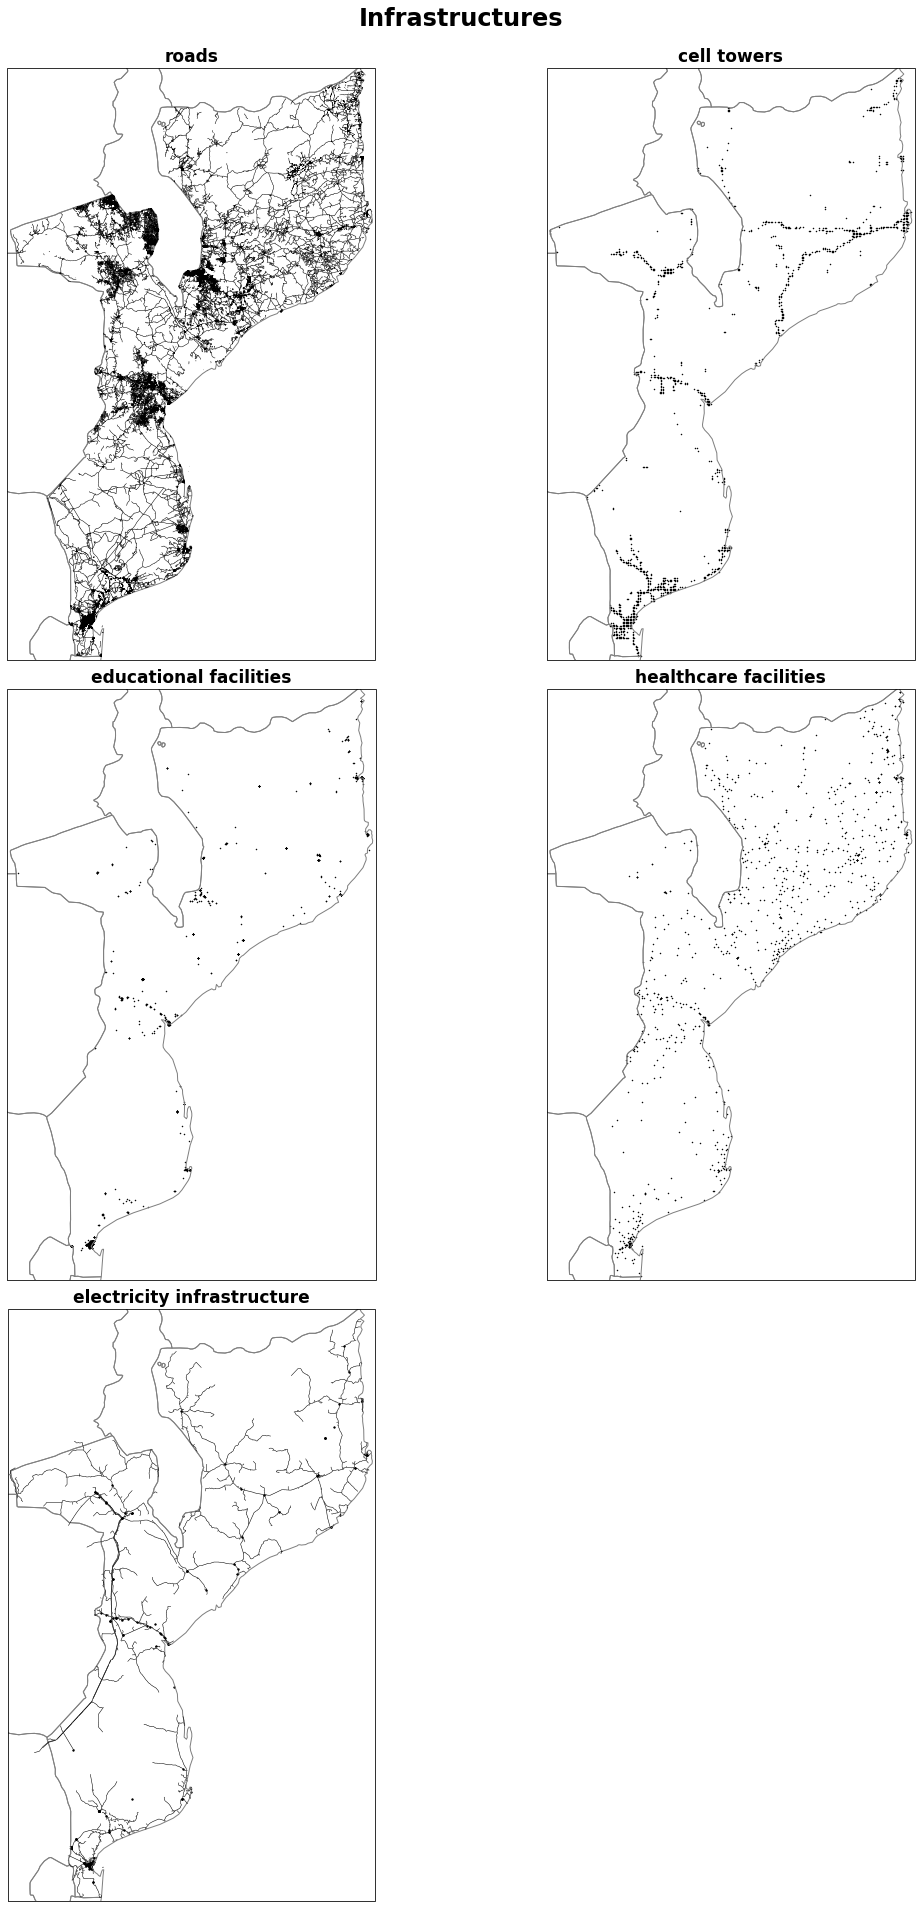

In [72]:
infra_plot(all_in_one_gdf, save_path=path_save_cntry+'plots/')

In [128]:
def infra_impact_plot(gdf, haz_tag, save_path=None, event_name=None):
    """ 
    per infrastructure, a plot of structural damages
    """
    
    border = cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', '50m')
    ci_types = set(gdf.ci_type).difference({'people', 'power_component', 'power_plant'})
    
    f, axes = plt.subplots(3, int(np.ceil(len(ci_types)/3)), 
                           subplot_kw=dict(projection=ccrs.PlateCarree()),
                           figsize=(16,20))

    for ci_type, ax in zip(ci_types, axes.flatten()):
        ax.set_extent(_get_extent(gdf), ccrs.PlateCarree())
        ax.add_feature(border, facecolor='none', edgecolor='0.5')
        
        if ci_type=='power_line':
            h_pl = gdf[(gdf.ci_type==ci_type)].plot(f'imp_dir_{haz_tag}', ax=ax, markersize=1, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=30000.)
            h_pc = gdf[(gdf.ci_type=='power_component') | (gdf.ci_type=='power_plant')
               ].plot(f'imp_dir_{haz_tag}', ax=ax, markersize=2, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=1.)
        elif ci_type=='road':
            h_rd = gdf[gdf.ci_type==ci_type].plot(f'imp_dir_{haz_tag}', ax=ax, markersize=0, linewidth=0.5, 
                                           transform=ccrs.PlateCarree(), vmin=0., vmax=30000.)
        else:
            h_imp = ax.scatter(gdf[gdf.ci_type==ci_type].geometry.x, 
                               gdf[gdf.ci_type==ci_type].geometry.y, 
                        c=gdf[gdf.ci_type==ci_type][f'imp_dir_{haz_tag}'],
                        transform=ccrs.PlateCarree(), s=2, vmin=0., vmax=1.)
        ax.set_title(f'{service_dict()[ci_type]}', weight='bold', fontsize=17)

    """ 
    cbar1 = mpu.colorbar(h_pl, axes.flatten()[-2], size=0.05, pad=0.15, 
                        orientation='horizontal')
    cbar1.set_label('Structural Damage Frac.')
    
    cbar2 = mpu.colorbar(h_imp, axes.flatten()[-2], size=0.05, pad=0.15, 
                        orientation='horizontal')
    cbar2.set_label('Structural Damage Frac.')
    """
    
    f.suptitle(f'Structural Damages from {event_name}', fontsize=24, weight='bold')
    if len(ci_types)%2>0:
        f.delaxes(axes[2,-1])
        
    if save_path:
        plt.savefig(f'{save_path}'+f'structural_impacts_{event_name}.pdf', 
        bbox_inches=None, pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [ ]:
infra_impact_plot(all_in_one_gdf, 'FL', save_path=path_save_cntry+'plots/', event_name='TC Idai Flooding')

In [ ]:
infra_impact_plot(all_in_one_gdf, 'TC', save_path=path_save_cntry+'plots/', event_name='TC Idai Wind')

<AxesSubplot:>

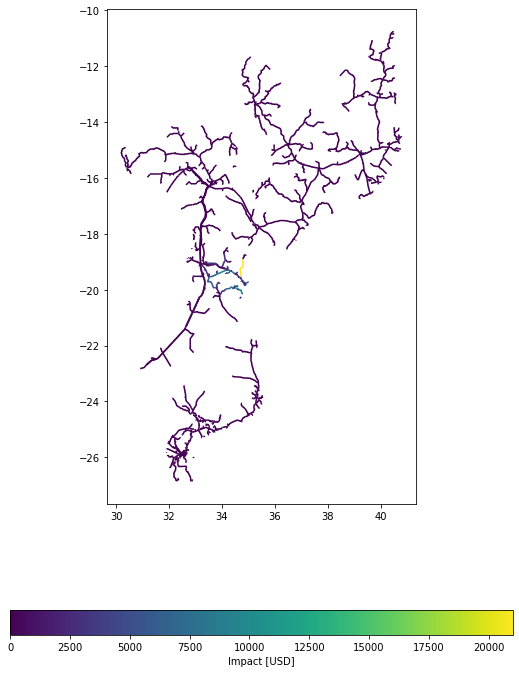

In [128]:
u_lp.plot_eai_exp_geom(imp_tc_pline)

<AxesSubplot:>

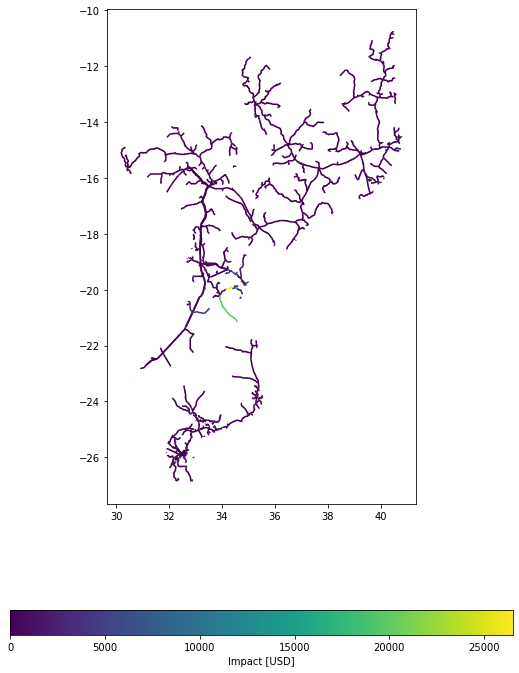

In [41]:
u_lp.plot_eai_exp_geom(imp_fl_pline)

<AxesSubplot:>

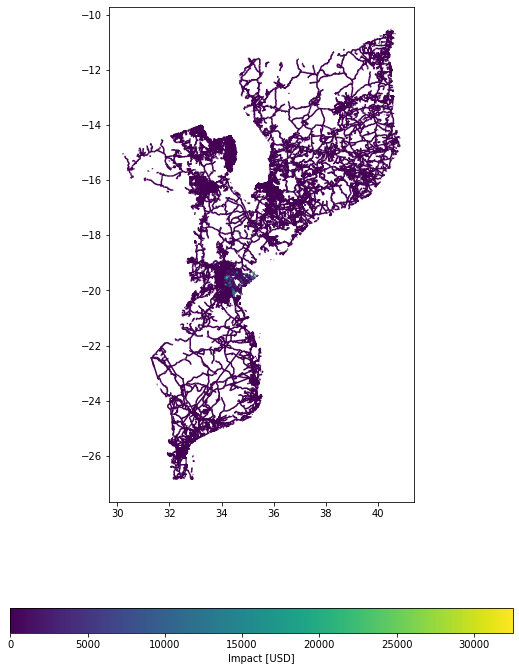

In [129]:
u_lp.plot_eai_exp_geom(imp_tc_road)

<AxesSubplot:>

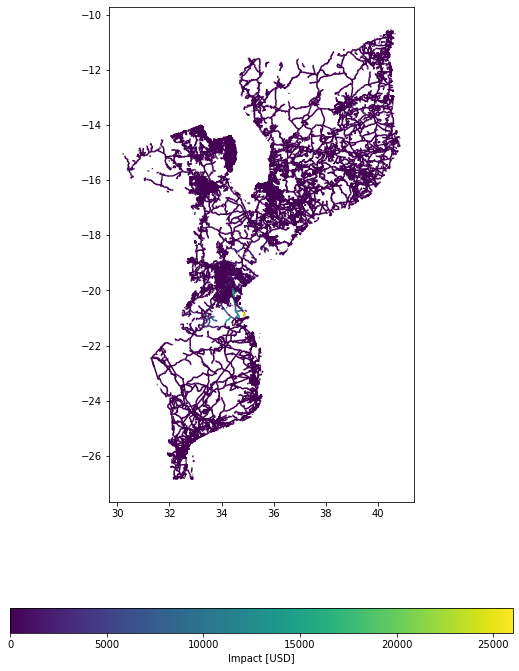

In [42]:
u_lp.plot_eai_exp_geom(imp_fl_road)

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

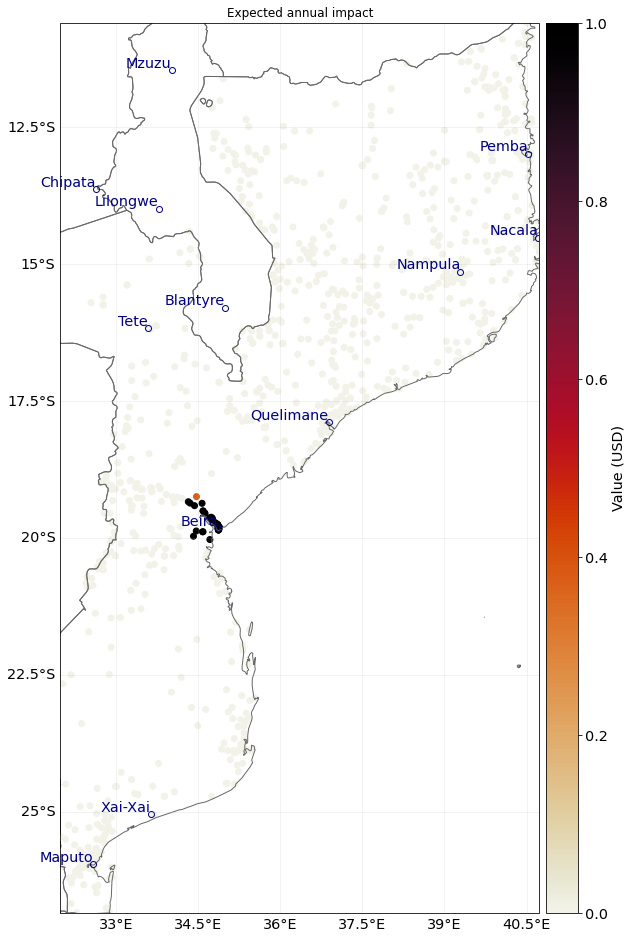

In [130]:
imp_tc_health.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

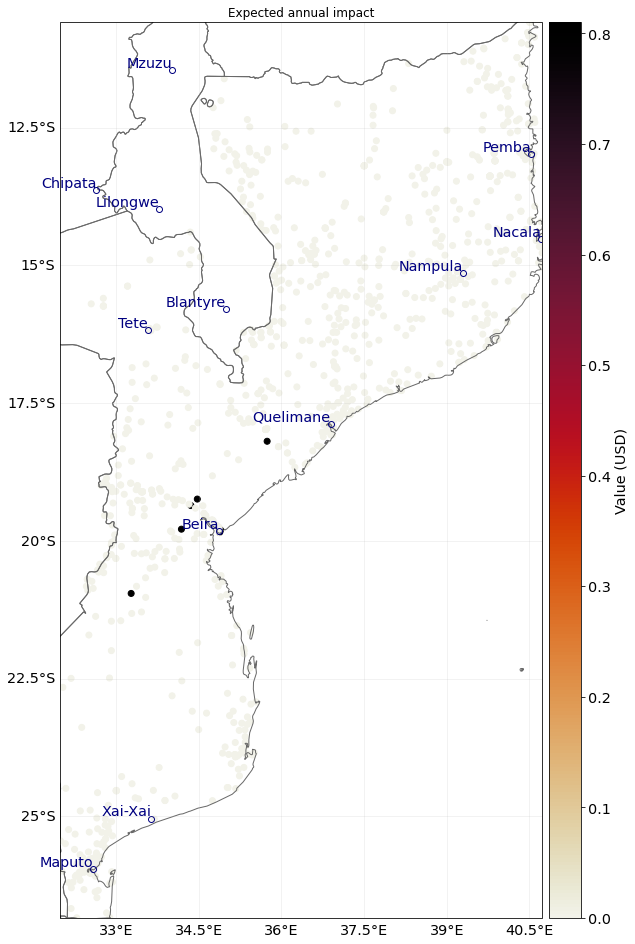

In [43]:
imp_fl_health.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

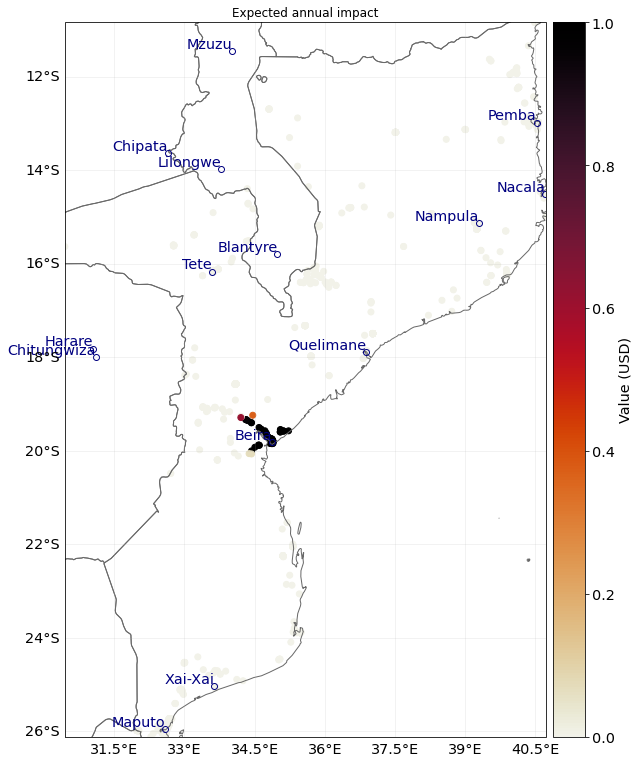

In [131]:
imp_tc_educ.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

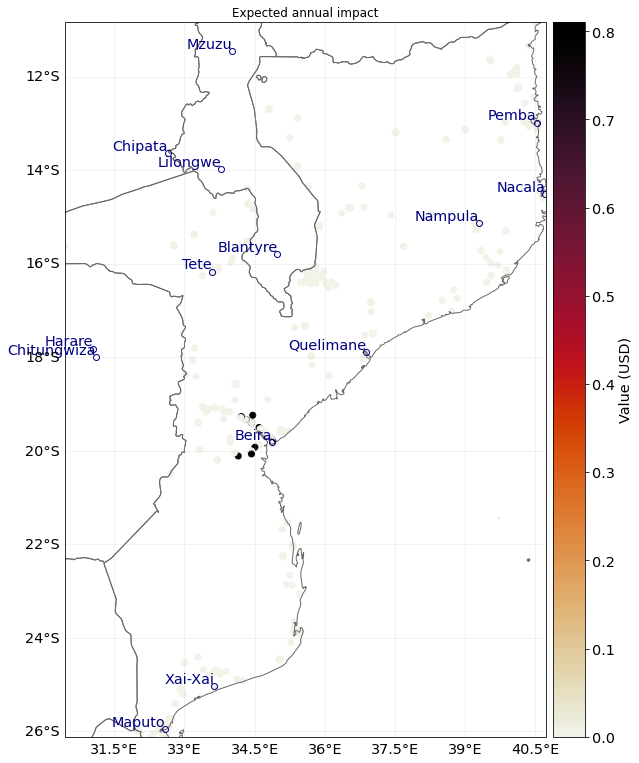

In [44]:
imp_fl_educ.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

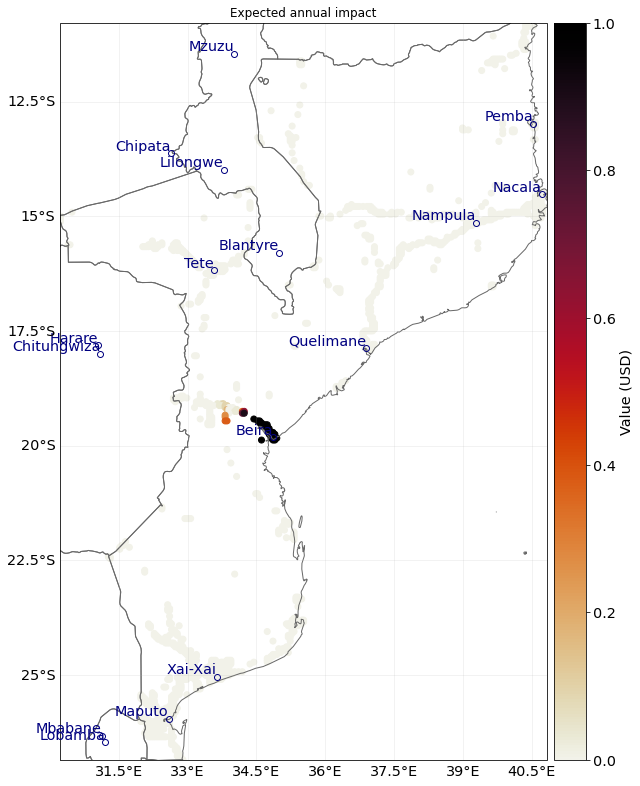

In [132]:
imp_tc_cell.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

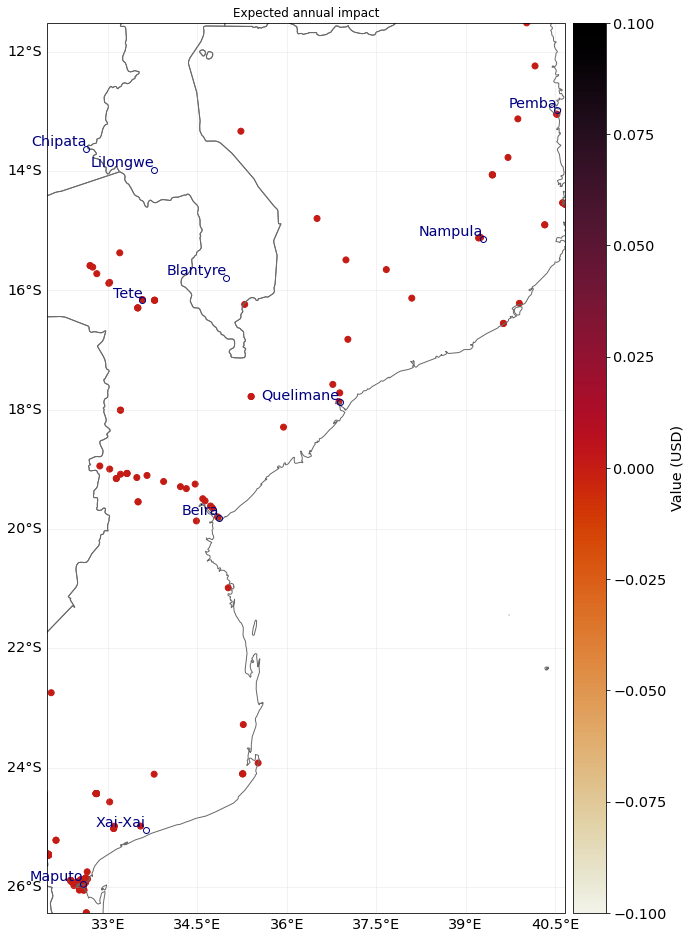

In [133]:
imp_tc_pcomp.plot_scatter_eai_exposure()

<GeoAxesSubplot:title={'center':'Expected annual impact'}>

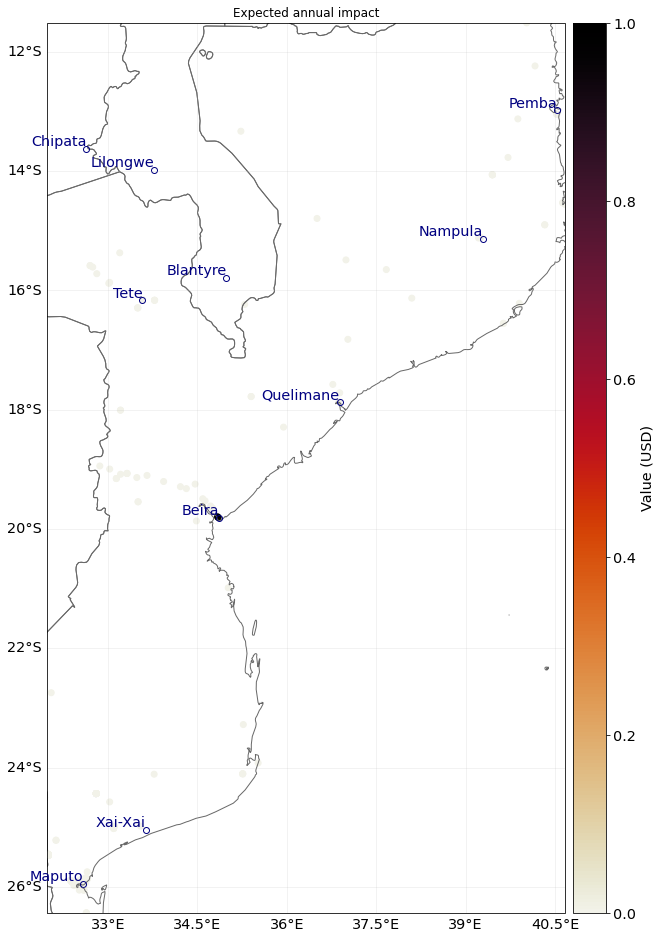

In [45]:
imp_fl_pcomp.plot_scatter_eai_exposure()